In [2]:
# imports including drive mount
from google.colab import drive
drive.mount('/content/drive')
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# load data
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# rescale data
X_train, X_valid, X_test = X_train / 255.0, X_valid / 255.0, X_test / 255.0
y_train = y_train.astype('float32')
y_valid = y_valid.astype('float32')
y_test = y_test.astype('float32')

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
# function to build a MLP model based on hyperparameters with loss=sparse_categorical_crossentropy, metrics=accuracy
def build_model(n_hidden=2, n_neurons=100, learning_rate=1e-3):
  model = keras.models.Sequential()
  model.add(keras.layers.Flatten(input_shape=[28, 28]))
  for layer in range(n_hidden):
    model.add(keras.layers.Dense(n_neurons, activation='relu'))
  model.add(keras.layers.Dense(10, activation='softmax')) # use softmax because multiclass classification problem
  optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
  model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model  

In [5]:
# define early stopping callback
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
# checkpoints for saving model during training
checkpoint_cb = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/mnist_mlp.h5', save_best_only=True)

Epoch 1/10
1688/1688 [==============================] - 8s 3ms/step - loss: 1.9084 - accuracy: 0.4764 - val_loss: 1.4360 - val_accuracy: 0.7123
Epoch 2/10
1688/1688 [==============================] - 5s 3ms/step - loss: 1.0699 - accuracy: 0.7772 - val_loss: 0.8140 - val_accuracy: 0.8117
Epoch 3/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.6918 - accuracy: 0.8340 - val_loss: 0.5994 - val_accuracy: 0.8522
Epoch 4/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.5491 - accuracy: 0.8594 - val_loss: 0.5030 - val_accuracy: 0.8693
Epoch 5/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4765 - accuracy: 0.8731 - val_loss: 0.4476 - val_accuracy: 0.8800
Epoch 6/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4321 - accuracy: 0.8824 - val_loss: 0.4109 - val_accuracy: 0.8897
Epoch 7/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4017 - accuracy: 0.8895 - val_loss: 0.3860 - val_accuracy:

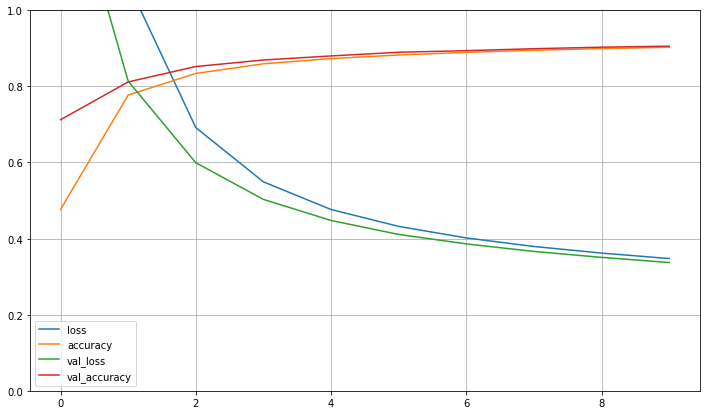

313/313 [==============================] - 1s 2ms/step - loss: 0.3243 - accuracy: 0.9099


[0.32432129979133606, 0.9099000096321106]

In [ ]:
# get an initial view with the default parameters
model = build_model()
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb, early_stopping_cb])
pd.DataFrame(history.history).plot(figsize=(12,7))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()
model.evaluate(X_test, y_test)

In [ ]:
# use scikit-learn wrapper for RandomizedSearchCV with early stopping
keras_classifier = keras.wrappers.scikit_learn.KerasClassifier(build_model)
# parameter distributions
param_distrib = {'n_hidden': [1, 2, 3, 4], 'n_neurons': np.arange(0,200, 10)}

random_search = RandomizedSearchCV(keras_classifier, param_distrib, n_iter=50, cv=3) # no scoring to use estimators (Keras MLP) scoring function
search_results = random_search.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb, early_stopping_cb])
# evaluate and save results to file
with open('/content/drive/MyDrive/mnist_mlp_training_results.txt', 'w') as result_file:
  result_file.write(f'Best result: {search_results.best_score_} using {search_results.best_params_} \n')
  means = search_results.cv_results_['mean_test_score']
  params = search_results.cv_results_['params']
  
  for mean, param in zip(means, params):
    result_file.write(f'{mean} with {param} \n')

Streaming output truncated to the last 5000 lines.
Epoch 77/100
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2520 - accuracy: 0.9285 - val_loss: 0.2557 - val_accuracy: 0.9277
Epoch 78/100
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2509 - accuracy: 0.9287 - val_loss: 0.2549 - val_accuracy: 0.9282
Epoch 79/100
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2498 - accuracy: 0.9292 - val_loss: 0.2537 - val_accuracy: 0.9285
Epoch 80/100
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2487 - accuracy: 0.9298 - val_loss: 0.2528 - val_accuracy: 0.9282
Epoch 81/100
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2477 - accuracy: 0.9297 - val_loss: 0.2516 - val_accuracy: 0.9280
Epoch 82/100
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2467 - accuracy: 0.9302 - val_loss: 0.2511 - val_accuracy: 0.9295
Epoch 83/100
1125/1125 [==============================] - 3s 3ms/step - l

1688/1688 [==============================] - 8s 5ms/step - loss: 1.5273 - accuracy: 0.4841 - val_loss: 2.3528 - val_accuracy: 0.0982


Text(0, 0.5, 'Loss')

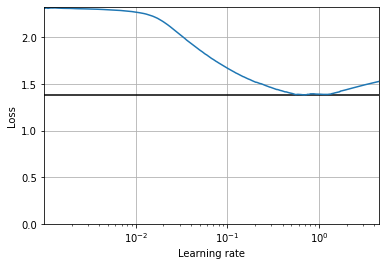

In [ ]:
# use optimal estimator to tune the learning rate
K = keras.backend

# build custom callback to change the learning rate after each batch
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)


model = build_model(n_hidden=4, n_neurons=70, learning_rate=1e-3)
expon_lr = ExponentialLearningRate(factor=1.005)

history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])


plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [9]:
# best model achieved
# best learning rate: 7e-1
model = build_model(n_hidden=2, n_neurons=300, learning_rate=4e-1)
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[early_stopping_cb, checkpoint_cb])

Epoch 1/100
1688/1688 [==============================] - 6s 4ms/step - loss: 0.2336 - accuracy: 0.9262 - val_loss: 0.2718 - val_accuracy: 0.9162
Epoch 2/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0956 - accuracy: 0.9714 - val_loss: 0.2571 - val_accuracy: 0.9148
Epoch 3/100
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0648 - accuracy: 0.9791 - val_loss: 0.1465 - val_accuracy: 0.9602
Epoch 4/100
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0481 - accuracy: 0.9845 - val_loss: 0.0946 - val_accuracy: 0.9747
Epoch 5/100
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0359 - accuracy: 0.9887 - val_loss: 0.0861 - val_accuracy: 0.9750
Epoch 6/100
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0301 - accuracy: 0.9905 - val_loss: 0.0908 - val_accuracy: 0.9745
Epoch 7/100
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0231 - accuracy: 0.9926 - val_loss: 0.3267 - val_ac

In [10]:
model = keras.models.load_model('/content/drive/MyDrive/mnist_mlp.h5') # rollback to best model
# predict / evaluate
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0819 - accuracy: 0.9837


[0.0818629115819931, 0.9836999773979187]

In [ ]:
# done & accuracy > 98 %